In [1]:
pwd

'/mmfs1/data/aglinska/BC-MRI-AE/misc/jacobian_pca'

In [213]:
import numpy as np 
import pandas as pd
import ants

from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
from scipy.stats import pearsonr,spearmanr,kendalltau

In [3]:
df = pd.read_csv('../../Data/ABIDE_legend_S982.csv')
patients = df['DxGroup'].values==1
df_asd = df.iloc[patients]

In [4]:
subs = df_asd['BIDS_ID'].values

In [5]:
fn_temp = '../../../jacobians/normed_Js_masked/{}_normed_Js_masked.nii'

In [6]:
ims = [ants.image_read(fn_temp.format(sub)) for sub in tqdm(subs)]

100%|██████████| 470/470 [00:04<00:00, 114.40it/s]


In [7]:
flatmap = np.array([im.numpy().flatten() for im in ims]) 
flatmap = flatmap[:,((flatmap**2).sum(axis=0)!=0)] # only analyze voxels with values > 0
flatmap = flatmap-flatmap.mean(axis=0) # center each voxel at zero
#flatmap = flatmap-flatmap.mean(axis=1)[:,np.newaxis] # center each subject at zero
flatmap.shape

(470, 55432)

## OVERALL PCA

In [239]:
from sklearn.decomposition import PCA
reducer = PCA()
reducer.fit(flatmap)
j_pca_all = reducer.transform(flatmap)

In [256]:
# Components needed to explain %90 of variance
print((np.cumsum(reducer.explained_variance_ratio_)<.9).sum())

103


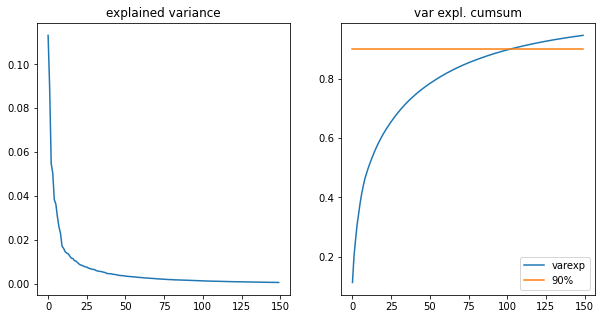

In [264]:
nplot = 150
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(reducer.explained_variance_ratio_[0:nplot])
plt.title('explained variance')
plt.subplot(1,2,2)
plt.plot(np.cumsum(reducer.explained_variance_ratio_[0:nplot]))
plt.plot(np.arange(nplot),np.repeat(.9,nplot))
plt.title('var expl. cumsum')
plt.legend(['varexp','90%'])

In [33]:
# LOSO PCA
ns = flatmap.shape[0]
j_pca_loso = np.array([PCA().fit(flatmap[np.arange(ns)!=s]).transform(flatmap[s,:][np.newaxis,:]) for s in tqdm(range(ns))])
j_pca_loso_2 = j_pca_loso[:,0,0:2]
j_pca_loso_2

100%|██████████| 470/470 [07:27<00:00,  1.05it/s]


In [271]:
## PLAY UMAP
flatmap

(470, 55432)

In [38]:
j_pca = j_pca_loso_2

In [216]:
#from scipy.stats import pearsonr
corr = kendalltau

In [215]:
jacobians_flat = np.array([im.numpy().flatten() for im in ims])

In [217]:
# DO X AXIS
res = np.array([corr(jacobians_flat[:,v],j_pca[:,0]) for v in tqdm(range(jacobians_flat.shape[1]))])
xcorr_r = res[:,0]
xcorr_p = res[:,1]

100%|██████████| 262144/262144 [01:02<00:00, 4172.12it/s]


In [218]:
# DO Y AXIS
res = np.array([corr(jacobians_flat[:,v],j_pca[:,1]) for v in tqdm(range(jacobians_flat.shape[1]))])
ycorr_r = res[:,0]
ycorr_p = res[:,1]

100%|██████████| 262144/262144 [01:02<00:00, 4193.38it/s]


In [43]:
# Runtime warning when correlating zero voxels, can ignore
#xcorr = np.array([np.corrcoef(jacobians_flat[:,v],j_pca[:,0])[0,1] for v in tqdm(range(jacobians_flat.shape[1]))])
#ycorr = np.array([np.corrcoef(jacobians_flat[:,v],j_pca[:,1])[0,1] for v in tqdm(range(jacobians_flat.shape[1]))])

In [219]:
# BONF CORRECT MAPS
xcorr_r_threshed = xcorr_r.copy()
ycorr_r_threshed = ycorr_r.copy()

p_thresh = .05/(~np.isnan(xcorr_p)).sum()

xcorr_r_threshed[xcorr_p>p_thresh]=np.nan
ycorr_r_threshed[ycorr_p>p_thresh]=np.nan

In [220]:
print((abs(xcorr_r_threshed[xcorr_p<p_thresh])).min())
print((abs(ycorr_r_threshed[ycorr_p<p_thresh])).min())

0.15162183005942928
0.15161344469350177


In [221]:
# plt.hist(xcorr_r_threshed[xcorr_p<p_thresh])
# plt.hist(ycorr_r_threshed[ycorr_p<p_thresh])

In [222]:
temp = ants.image_read('single_subj_T1.nii')
temp = temp.resample_image(resample_params=(64,64,64), use_voxels=True, interp_type=1)

In [223]:
xcorr_nii = ims[0].new_image_like(xcorr_r_threshed.reshape((64,64,64))) #.plot_ortho(flat=True,black_bg=True,cmap='bwr')
ycorr_nii = ims[0].new_image_like(ycorr_r_threshed.reshape((64,64,64))) #.plot_ortho(flat=True,black_bg=True,cmap='bwr')

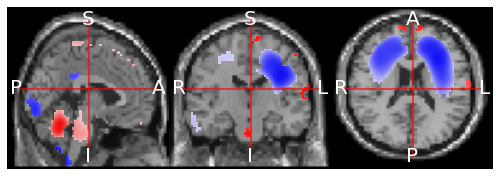

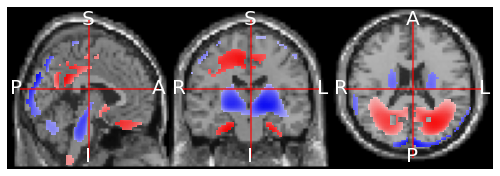

In [224]:
temp.plot_ortho(xcorr_nii,flat=True,black_bg=True,cmap='gray',overlay_cmap='bwr')
temp.plot_ortho(ycorr_nii,flat=True,black_bg=True,cmap='gray',overlay_cmap='bwr')

In [225]:
ycorr_r_threshed[np.isnan(ycorr_r_threshed)]=0
xcorr_r_threshed[np.isnan(xcorr_r_threshed)]=0

ims[0].new_image_like(xcorr_r_threshed.reshape((64,64,64))).to_filename('xcorr-bonf.nii')
ims[0].new_image_like(ycorr_r_threshed.reshape((64,64,64))).to_filename('ycorr-bonf.nii')

In [228]:
print(np.nanmin(xcorr_r).round(3),np.nanmean(xcorr_r).round(3),np.nanmax(xcorr_r).round(3))
print(np.nanmin(ycorr_r).round(3),np.nanmean(ycorr_r).round(3),np.nanmax(ycorr_r).round(3))

-0.521 -0.045 0.585
-0.453 0.005 0.577


## CORRELATE PCA W/ SYMPTOMS

In [267]:
# CORR PCA W/ SYMOTOMS
corr = pearsonr
corr = kendalltau

keys = ['AgeAtScan','FIQ','ADOS_Comm', 'ADOS_Social', 'ADOS_StBeh','ADI_R_SocialTotal', 'ADI_R_VerbalTotal', 'ADI_R_RRB','ADI_R_Onset Total']
npcs = 10 # How many PCs
# Make dataframe
col1 = list()
col2 = list()
for key in keys:
    for i in ['r','p']:
        col1.append(key)
        col2.append(i)
#columns = [[key,key],['r','p']]
columns = [col1,col2]
res_corr = pd.DataFrame(np.zeros((npcs,len(col1))),columns=columns)

for key in keys:
    for pc in range(npcs):
        vec_behav = df[key].values[patients]
        vec_pca = j_pca_loso[:,0,pc]
        #vec_pca = j_pca[:,pc]
        e = np.isnan(vec_behav)
        r,p = corr(vec_behav[~e],vec_pca[~e])
        res_corr.loc[pc].at[(key,'r')] = r
        res_corr.loc[pc].at[(key,'p')] = p
        #res_corr.loc[pc].at[(key,'n')] = len(vec_behav[~e])

In [268]:
pd.options.display.max_columns = None
res_corr

AgeAtScan                 FIQ           ADOS_Comm           ADOS_Social  \
          r         p         r         p         r         p           r   
0  0.057140  0.064370  0.004525  0.889681  0.092896  0.017455    0.056288   
1  0.043463  0.159456  0.016245  0.618488  0.080827  0.038626   -0.042589   
2  0.069618  0.024227 -0.107050  0.001032  0.122006  0.001797    0.019626   
3 -0.088216  0.004296  0.023352  0.474074 -0.092747  0.017636   -0.014871   
4 -0.022921  0.458112  0.026332  0.419546 -0.065618  0.093152   -0.010967   
5 -0.068310  0.027023 -0.052819  0.105414 -0.033369  0.393192    0.019129   
6 -0.027008  0.381986 -0.039708  0.223512 -0.010837  0.781562   -0.006672   
7  0.077228  0.012424  0.055578  0.088431 -0.054183  0.165619   -0.006708   
8  0.015747  0.610241  0.031298  0.337332  0.065282  0.094841    0.003514   
9  0.014712  0.633919  0.034521  0.289948  0.022533  0.564238    0.025411   

            ADOS_StBeh           ADI_R_SocialTotal            \
          p          r         p                 r         p   
0  0.136015   0.098143  0.023156          0.042289  0.278463   
1  0.259333  -0.061405  0.155377         -0.023770  0.542405   
2  0.603199  -0.067564  0.117978          0.048848  0.210618   
3  0.693693   0.016527  0.702166         -0.009624  0.805188   
4  0.771471  -0.010807  0.802545          0.002336  0.952256   
5  0.612404  -0.020927  0.628243          0.003922  0.919929   
6  0.859732   0.048920  0.257666         -0.031101  0.425427   
7  0.858994  -0.058435  0.176352         -0.058408  0.134431   
8  0.925858  -0.047545  0.271284         -0.107920  0.005679   
9  0.500934  -0.021641  0.616551          0.022441  0.565208   

  ADI_R_VerbalTotal           ADI_R_RRB           ADI_R_Onset Total            
                  r         p         r         p                 r         p  
0          0.007433  0.849078 -0.043311  0.279294          0.021979  0.618564  
1          0.025932  0.506788 -0.010662  0.789983         -0.006015  0.891613  
2          0.055366  0.156374 -0.010927  0.784882          0.034704  0.431787  
3          0.024137  0.536632  0.013980  0.726927          0.039562  0.370148  
4          0.012005  0.758603 -0.001150  0.977078          0.010469  0.812539  
5          0.006878  0.860233 -0.005884  0.883148         -0.022615  0.608442  
6         -0.026487  0.497731  0.021633  0.588921         -0.045404  0.303701  
7         -0.066346  0.089424  0.064767  0.105687         -0.023599  0.592945  
8         -0.116073  0.002964  0.042824  0.284732         -0.107119  0.015243  
9          0.033023  0.397891  0.038002  0.342472         -0.003008  0.945681

In [269]:
for pc in range(res_corr.shape[0]):
    for key in keys:
        p = res_corr[key]['p'][pc]
        if p < .05:
            print('PC {} - {} | r = {:.3f},p = {:.3f}'.format(pc,key,res_corr[key]['r'][pc],res_corr[key]['p'][pc]))

PC 0 - ADOS_Comm | r = 0.093,p = 0.017
PC 0 - ADOS_StBeh | r = 0.098,p = 0.023
PC 1 - ADOS_Comm | r = 0.081,p = 0.039
PC 2 - AgeAtScan | r = 0.070,p = 0.024
PC 2 - FIQ | r = -0.107,p = 0.001
PC 2 - ADOS_Comm | r = 0.122,p = 0.002
PC 3 - AgeAtScan | r = -0.088,p = 0.004
PC 3 - ADOS_Comm | r = -0.093,p = 0.018
PC 5 - AgeAtScan | r = -0.068,p = 0.027
PC 7 - AgeAtScan | r = 0.077,p = 0.012
PC 8 - ADI_R_SocialTotal | r = -0.108,p = 0.006
PC 8 - ADI_R_VerbalTotal | r = -0.116,p = 0.003
PC 8 - ADI_R_Onset Total | r = -0.107,p = 0.015


In [286]:
import os
gene_dir = '../../Data/gene_epression_maps/'
genefiles = os.listdir(gene_dir);genefiles.sort()
genefiles

['gene_1098_CHD2_1106.0.nii.gz',
 'gene_150958_ASH1L-AS1_645676.0.nii.gz',
 'gene_1847_DYRK1A_1859.0.nii.gz',
 'gene_22696_SHANK2_22941.0.nii.gz',
 'gene_22881_POGZ_23126.0.nii.gz',
 'gene_30427_SHANK1_50944.0.nii.gz',
 'gene_30768_CHCHD8_51287.0.nii.gz',
 'gene_35158_ASH1L_55870.0.nii.gz',
 'gene_36765_ARID1B_57492.0.nii.gz',
 'gene_59528_SHANK3_85358.0.nii.gz',
 'gene_85618_SHANK2-AS3_220070.0.nii.gz',
 'gene_8754_SYNGAP1_8831.0.nii.gz']

In [288]:
genemaps = [ants.image_read(os.path.join(gene_dir,genefile)) for genefile in genefiles]
genemaps = [genemap.resample_image(resample_params=(64,64,64), use_voxels=True, interp_type=1) for genemap in genemaps]